In [31]:
import pandas as pd 
import anndata as ad 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import math
import os
from matplotlib import cm
import crested
import keras
from IPython.display import display
import scanpy as sc

%matplotlib inline

In [32]:
pd.set_option('display.max_columns', None)

## REGISTER THE GENOME:
genome_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/references/human/10x/grch38.p2/genome/fasta/genome.fa"
genome = crested.Genome(genome_path)
crested.register_genome(genome)

model_path = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/human/99.keras"
model = keras.models.load_model(model_path, compile = False)

adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/data/human/crested_adata/human_basalganglia_hmba_pre-print_crested.h5ad")

2025-08-05T11:12:36.449647-0700 INFO Genome genome registered.


In [33]:
def get_mutation(ref_nucleotide, effect_allele, other_allele):
    """
    Determines the mutated nucleotide based on the reference nucleotide and the alleles (effect and other).
    
    Parameters:
    ref_nucleotide (str): The reference nucleotide from the genome sequence.
    effect_allele (str): The effect allele.
    other_allele (str): The other allele.
    
    Returns:
    str or None: The mutated nucleotide if the mutation is valid, otherwise None.
    """
    
    if ref_nucleotide == effect_allele:
        print("Reference nucleotide is on the effect allele.")
        return other_allele  # Mutation is the 'other' allele
    elif ref_nucleotide == other_allele:
        print("Reference nucleotide is on the other allele.")
        return effect_allele  # Mutation is the 'effect' allele
    else:
        print("Reference nucleotide does not match either allele.")
        return None  # Invalid mutation or alignment issue

In [34]:
def plot_variant_specific_scores(peaks_below_500, rs_id):
    
    """
    Computes the predicted regulatory impact of a SNP mutation within a peak using a CRESTED model.

    This function extracts the reference sequence around the SNP, mutates it based on effect and other alleles 
    (based on the phenotype), and computes prediction scores on both reference and mutated sequences.

    Parameters:
    ----------
    peaks_below_500 : pd.DataFrame
        DataFrame containing SNPs and peak annotations, including rsid, alleles, coordinates, etc.
    rs_id : str
        The rsID of the SNP to analyze.

    Global Requirements:
    --------------------
    - `pheno` (str): global variable indicating the phenotype ("SCZ", "PTSD", "Alzheimer", "Depression")
    - `genome` : pysam.FastaFile object or equivalent providing `.fetch()` for sequence retrieval
    - `model` : trained CRESTED model object
    - `get_mutation()` : function to get the mutated nucleotide from ref/effect/other alleles

    Returns:
    -------
    original_pred : np.ndarray
        CRESTED prediction on the reference sequence.
    mutated_pred : np.ndarray
        CRESTED prediction on the mutated sequence.
    sequence : str
        Original reference sequence.
    mutated_sequence : str
        Sequence with the SNP mutated.
    SNP_position : int
        Genomic position of the SNP.
    start : int
        Start coordinate of the peak.
    ref_nucleotide : str
        Reference nucleotide at the SNP position.
    """

    chrom = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "peak_chr"].values[0]
    start = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "peak_start"].values[0]
    print(start)
    end = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "peak_end"].values[0]
    SNP_position = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "snp_end_POS_hg38"].values[0].astype(int)
    
    sequence = genome.fetch(chrom, start - 1, end - 1)
    sequence_list = list(sequence)

    if pheno == "SCZ" or pheno == "PTSD" : 
            
            effect_allele = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "A1"].values[0]
            other_allele = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "A2"].values[0]
            effect_size = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "BETA"].values[0]


    elif pheno == "Alzheimer":
    
            effect_allele = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "effect_allele"].values[0]
            other_allele = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "other_allele"].values[0]
            effect_size = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "beta"].values[0]

    elif pheno == "Depression":

            effect_allele = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "EA"].values[0]
            other_allele = peaks_below_500.loc[peaks_below_500["rsid"] == rs_id, "NEA"].values[0]



    ref_nucleotide = genome.fetch(chrom, SNP_position - 1, SNP_position)
    
    mutation = get_mutation(ref_nucleotide, effect_allele, other_allele)
    if not mutation:
        print("No valid mutation identified")
        return
    
    sequence_list[SNP_position - start] = mutation
    mutated_sequence = "".join(sequence_list)

    ## COMPUTE THE PREDICTION SCORES FOR ALL CELL TYPES: 
    original_pred = crested.tl.predict(sequence, model)
    mutated_pred = crested.tl.predict(mutated_sequence, model)

    

    return np.squeeze(original_pred), np.squeeze(mutated_pred), sequence, mutated_sequence, SNP_position, start, ref_nucleotide, effect_size

In [5]:
def CT_specific_mutation_plot(delta):

    cell_types = list(adata.obs_names)

    assert len(delta) == len(cell_types), "Length mismatch between predictions and cell types"

    plt.figure(figsize=(12,5))
    plt.bar(range(len(delta)), delta)
    plt.xticks(ticks = range(len(cell_types)), labels = cell_types, rotation = 90)
    plt.ylabel("Δ prediction score (mutated - original)")
    plt.title("Impact of SNP on predicted regulatory activity across cell types")
    plt.tight_layout()
    plt.show()

In [ ]:
pheno = "SCZ"   #"PTSD" #"SCZ" #"Alzheimer"

## Significant Groups from MAGMA

CT_interest = [
    'AMY-SLEA-BNST_GABA', 'GPe_MEIS2-SOX6_GABA', 'LAMP5-CXCL14_GABA', 'LAMP5-LHX6_GABA', 'OB_FRMD7_GABA', 'OT_D1_ICj',
    'STR_LYPD6-RSPO2_GABA', 'STR_SST-RSPO2_GABA', 'STR-BF_TAC3-PLPP4-LHX8_GABA', 'STRd_Cholinergic_GABA',
    'STRd_D1_Striosome_MSN', 'STRd_D2_Matrix_MSN', 'STRd_D2_StrioMat_Hybrid_MSN', 'STRd_D2_Striosome_MSN',
    'STRv_D1_MSN', 'STRv_D1_NUDAP_MSN', 'STRv_D2_MSN', 'VIP_GABA'
]


#CT_interest = ['BAM', 'ImAstro', 'ImOligo', 'Microglia', 'T_cells']

In [ ]:
# === Compute delta predictions across cell types for selected SNPs ===

all_dfs = []
all_effect_dfs = [] 


for cell_type in CT_interest:
    print(f"Processing {cell_type}...")

    # Load peaks associated with the current cell type and phenotype
    peaks_file = f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/BasalGanglia/external/Disease_related/CRESTED_results/snps_peaks_BG/{pheno}/{pheno}_{cell_type}_peaks.tsv"
    peaks_below_500 = pd.read_csv(peaks_file, sep="\t")

    # Initialize dictionary to store delta predictions for each SNP
    all_delta_predictions = {}
    effect_size_dict = {}

    for rsid in peaks_below_500["rsid"]:
        try:
            # Compute prediction for reference and mutated sequence
            original_pred, mutated_pred, sequence, mutated_sequence, SNP_position, start, ref_nucleotide, effect_size = plot_variant_specific_scores(peaks_below_500, rsid)
            
            # Compute the difference between reference and mutated prediction
            delta_pred = original_pred - mutated_pred

            # Store delta prediction vector (1 value per cell) per SNP
            all_delta_predictions[rsid] = delta_pred

            effect_size_dict[rsid] = effect_size

        except Exception as e:
            print(f"Skipping {rsid} in {cell_type}: {e}")

    # Build a DataFrame: rows = SNPs, columns = cells + cell type
    df_delta = pd.DataFrame.from_dict(all_delta_predictions, orient="index", columns=list(adata.obs_names))
    df_delta.index.name = "rsid"
    df_delta["cell_type"] = cell_type
    all_dfs.append(df_delta)

    # Create a seperate datafrme with the effect_sizes
    df_effect = pd.DataFrame.from_dict(effect_size_dict, orient="index", columns=["effect_size"])
    df_effect.index.name = "rsid"
    all_effect_dfs.append(df_effect)

# Concatenate all cell type-specific DataFrames
# final_df: one row per SNP per cell type, columns = prediction deltas for each cell + cell_type + rsid
final_df = pd.concat(all_dfs).reset_index()

effect_size_df = pd.concat(all_effect_dfs)
effect_size_df.index.name = "rsid" 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap, ScalarMappable
import matplotlib.lines as mlines

def plot_prediction_scatter_grid(signed_scaled_delta,
                                  magnitude_delta,
                                  df_valid,
                                  output_names,
                                  size_scale=300,
                                  font_size=9,
                                  figsize=(14, 17),
                                 cmap='magma',
                                save_path=None,
    ):
    """
    Creates a labeled scatter dot plot with two colorbars:
    - Dot color encodes the min-max standardized effect of the mutation on the prediction accessibility.
    - Dot size encodes the magnitude of the effect

    Parameters:
    - signed_scaled_delta: 2D array-like of shape (n_rows, n_cols)
    - magnitude_delta: 2D array-like of shape (n_rows, n_cols)
    - df_valid: DataFrame with index as row labels and an 'effect_size' column
    - output_names: List of column labels (length n_cols)
    - size_scale: Scalar to control dot size
    - font_size: Font size for axis and colorbar labels
    - figsize: Size of the full figure
    """
    n_rows, n_cols = signed_scaled_delta.shape
    x, y = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
    x = x.flatten()
    y = y.flatten()

    # Dot size and color

    #### Previous version: (No Log-transform) 
    magnitude_delta = np.clip(magnitude_delta, a_min=None, a_max=100) # 150 different caps tested
    sizes = magnitude_delta.flatten() * size_scale
    # Example values for the dot size's legend
    #-magnitude_values = magnitude_delta.flatten()
    example_magnitudes = [10, 50, 100]
    example_scaled_sizes = [val * size_scale for val in example_magnitudes]



    max_per_row = magnitude_delta.max(axis=1)  # shape = (n_rows,)


    color_norm = Normalize(vmin=signed_scaled_delta.min(), vmax=signed_scaled_delta.max())
    colors = get_cmap(cmap)(color_norm(signed_scaled_delta.flatten()))
 

    # Begin plotting
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 4, width_ratios=[0.15, 0.02, 1, 0.05], wspace=0.05)

    # Row labels
    ax_labels = fig.add_subplot(gs[0, 0])

        # Level of labeling color strip
    #level_series = df_valid["effect_size"]
    #level_norm = Normalize(vmin=level_series.min(), vmax=level_series.max())
    #level_cmap = get_cmap("PiYG")
    #level_colors = level_cmap(level_norm(level_series.values))
    #level_colors_flipped = level_colors[::-1]  # to match y-axis

    #ax_colors = fig.add_subplot(gs[0, 1])
    #ax_colors.imshow(level_colors_flipped[:, np.newaxis], aspect="auto", origin="upper")
    #ax_colors.set_xticks([])
    #ax_colors.set_yticks(np.arange(n_rows))
    #ax_colors.set_yticklabels([])  # y-tick labels are already shown on the left
    #ax_colors.invert_yaxis()

    ax_labels.set_xlim(0, 1)
    ax_labels.set_ylim(n_rows - 0.5, -0.5)
    for i, label in enumerate(df_valid.index):
        ax_labels.text(1, i, label, ha='right', va='center', fontsize=font_size)
    ax_labels.axis("off")


    # Main scatter plot
    ax_main = fig.add_subplot(gs[0, 2])
    sc = ax_main.scatter(x, y, s=sizes, c=colors)
    ax_main.set_xticks(np.arange(n_cols))
    ax_main.set_xticklabels(output_names, rotation=60)
    for label in ax_main.get_xticklabels():
        label.set_horizontalalignment('right')

    ax_main.set_yticks(np.arange(n_rows))
    ax_main.set_yticklabels([])  # already shown in ax_labels
    ax_main.set_ylim(n_rows - 0.5, -0.5)
    
    ax_main.set_xlabel("Group", fontsize=font_size)
    ax_main.set_ylabel("", fontsize=font_size)

    ax_main.tick_params(axis='x', labelsize=font_size)
    ax_labels.tick_params(axis='y', labelsize=font_size)

    legend_handles = [
        plt.scatter([], [], s=sz, color="gray", label=f"{val:.2f}")
        for val, sz in zip(example_magnitudes, example_scaled_sizes)
    ]

    ax_main.legend(
        handles=legend_handles,
        title="|Δ prediction|",
        labelspacing=2.0,
        borderpad=1,
        loc="lower left",
        bbox_to_anchor=(1.02, -0.3),
        fontsize=font_size,
        title_fontsize=font_size
    )

    # Colorbars
    cax_strength = fig.add_axes([0.91, 0.55, 0.015, 0.30])
    cb = plt.colorbar(ScalarMappable(norm=color_norm, cmap=cmap), cax=cax_strength)
    cb.set_label("Scaled Delta Prediction Score", fontsize=font_size - 3)
    cb.ax.tick_params(labelsize=font_size)

    # Colorbar for the Effect Size
    #cax_level = fig.add_axes([0.91, 0.10, 0.015, 0.35])
    #cb2 = plt.colorbar(ScalarMappable(norm=level_norm, cmap=level_cmap), cax=cax_level)
    #cb2.set_label("Effect Size", fontsize=font_size)
    #cb2.ax.tick_params(labelsize=font_size)
    #cb2.ax.yaxis.set_label_position('right')
    #cb2.ax.yaxis.set_ticks_position('right')


    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
 


In [ ]:
heatmap_df = final_df.set_index(["rsid", "cell_type"])[CT_interest]
print(heatmap_df)

## EXTRACT THE SNPs WITH THE HIGHEST EFFECT
row_max_abs = heatmap_df.abs().max(axis=1)
top20_df = heatmap_df.loc[row_max_abs.nlargest(20).index]
#top20_df = heatmap_df
rsid_list = [rsid for rsid, _ in top20_df.index]
print(rsid_list)

                               AMY-SLEA-BNST_GABA  GPe_MEIS2-SOX6_GABA  \
rsid       cell_type                                                     
rs308696   AMY-SLEA-BNST_GABA           -2.841034            -0.916451   
rs308697   AMY-SLEA-BNST_GABA            0.454483             0.491165   
rs308695   AMY-SLEA-BNST_GABA            6.652847            -2.050106   
rs4650206  AMY-SLEA-BNST_GABA           -0.112549            -0.282837   
rs4074990  AMY-SLEA-BNST_GABA           -1.207886            -3.291145   
...                                           ...                  ...   
rs2743942  VIP_GABA                     -0.733768            -1.100788   
rs1737015  VIP_GABA                     -0.410828            -1.160984   
rs1737013  VIP_GABA                      0.002708             0.006832   
rs1737014  VIP_GABA                     -0.155159            -0.146496   
rs10906984 VIP_GABA                     -0.043167            -0.633430   

                               LAMP5-

In [39]:
## IMPORT THE GENES-SNPS pairs from MAGMA

from mygene import MyGeneInfo
import pandas as pd

# Load Genes-SNPs associations from MAGMA
with open("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/MAGMA_analysis/SCZ_2022_final_taxonomy/european/PGC3_SCZ_wave3.european.autosome.public.v3.vcf.tsv_no_heading.step1.genes.annot", "r") as f:
    lines = [line.strip().split("\t") for line in f if not line.startswith("#")]

gene_snp_pairs = [
    (row[0], snp) for row in lines for snp in row[2:]
]

df_gene_snp = pd.DataFrame(gene_snp_pairs, columns=["Gene", "SNP"])


# Map ENTREZ IDs to Gene Symbols
mg = MyGeneInfo()
dict_SNPs_Genes = {}

for rsid in rsid_list:
    print(rsid)
    try:
        subset = df_gene_snp[df_gene_snp["SNP"] == rsid]

        if subset.empty:
            print(f"{rsid} → SNP not found")
            dict_SNPs_Genes[rsid] = None
            continue

        gene_ID = subset["Gene"].values[0]
        gene_info = mg.querymany(gene_ID, scopes="entrezgene", fields="symbol", species="human")

        # Récupérer le symbole s’il est disponible
        if gene_info and isinstance(gene_info, list):
            symbol = gene_info[0].get("symbol", None)
        else:
            symbol = None

        dict_SNPs_Genes[rsid] = symbol
        print(f'{rsid} → {symbol}')

    except Exception as e:
        print(f"Error with {rsid}: {e}")
        dict_SNPs_Genes[rsid] = None


rs308696
rs308696 → SNP not found
rs308697
rs308697 → SNP not found
rs308695
rs308695 → SNP not found
rs4650206
rs4650206 → SNP not found
rs4074990
rs4074990 → SNP not found
rs6892290
querying 1-1...done.
Finished.
rs6892290 → HCN1
rs6892594
querying 1-1...done.
Finished.
rs6892594 → HCN1
rs56280222
querying 1-1...done.
Finished.
rs56280222 → CRHR1
rs62054384
querying 1-1...done.
Finished.
rs62054384 → CRHR1
rs9897399
querying 1-1...done.
Finished.
rs9897399 → CRHR1
rs62054383
querying 1-1...done.
Finished.
rs62054383 → CRHR1
rs62054382
querying 1-1...done.
Finished.
rs62054382 → CRHR1
rs10514879
querying 1-1...done.
Finished.
rs10514879 → CRHR1
rs1076614
querying 1-1...done.
Finished.
rs1076614 → CACNA1I
rs1883123
querying 1-1...done.
Finished.
rs1883123 → CACNA1I
rs118134308
querying 1-1...done.
Finished.
rs118134308 → TCF4
rs13438979
querying 1-1...done.
Finished.
rs13438979 → TSNARE1
rs7828173
querying 1-1...done.
Finished.
rs7828173 → TSNARE1
rs13262595
querying 1-1...done.
Finish

In [40]:
list_genes_connected = [snp for snp, gene in dict_SNPs_Genes.items() if gene is not None]
print(list_genes_connected)

effect_size_df_subset = effect_size_df.loc[effect_size_df.index.isin(list_genes_connected)]
print(effect_size_df_subset.head())

['rs6892290', 'rs6892594', 'rs56280222', 'rs62054384', 'rs9897399', 'rs62054383', 'rs62054382', 'rs10514879', 'rs1076614', 'rs1883123', 'rs118134308', 'rs13438979', 'rs7828173', 'rs13262595', 'rs59554395', 'rs34643171', 'rs4976982', 'rs607296', 'rs9259970', 'rs34166054', 'rs9380052', 'rs9366715', 'rs34466819', 'rs476167', 'rs72694945', 'rs13250766', 'rs7465202', 'rs7571545', 'rs7571869', 'rs7587043', 'rs7587598', 'rs1113736', 'rs7177514', 'rs6914052', 'rs2711117', 'rs1610602', 'rs696814', 'rs700670', 'rs696815', 'rs1748769', 'rs1616547', 'rs1624537', 'rs9318638', 'rs10906984']
            effect_size
rsid                   
rs6892290     -0.053601
rs6892594     -0.054203
rs56280222     0.061500
rs62054384     0.061500
rs9897399     -0.062397


In [ ]:
## Top 20 SNPs with the largest effect & connected with a SNP

df_to_plot = top20_df #top20_df #heatmap_df
df_to_plot = heatmap_df[heatmap_df.index.get_level_values(0).isin(list_genes_connected)]


#####################
## ORDER OF THE GROUPS : 
#######################

## Excel File with all annotations for the Basal ganglia Cell Atlas: 

sheet_id = "1NwO-_BQumtfVYcTNP--vRa5434Elvj5me1oEKV1Q-gE"
gid = "818330981"  # C’est l’onglet spécifique
url_csv = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

order_annotations = pd.read_csv(url_csv)
order_annotations = order_annotations[["Group", "display_order_group"]]
order_annotations["Group"] = order_annotations["Group"].str.replace(" ","_")
order_annotations_subset = order_annotations[order_annotations["Group"].isin(CT_interest)].copy()

# Reindex
order_annotations_subset = order_annotations_subset.reset_index(drop=True)
order_annotations_subset["display_order_group"] = range(len(order_annotations_subset))
ordered_groups = order_annotations_subset["Group"].tolist()
df_to_plot = df_to_plot[ordered_groups]

print(df_to_plot.head())
df_to_plot.to_csv(f"/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/CRESTED_analysis/{pheno}_recap_variants_accessibility.csv", sep = "\t")

                                STRd_D1_Striosome_MSN  STRd_D2_Matrix_MSN  \
rsid       cell_type                                                        
rs6892290  AMY-SLEA-BNST_GABA                1.212883            1.428120   
rs6892594  AMY-SLEA-BNST_GABA               -0.155167           -0.192444   
rs56280222 GPe_MEIS2-SOX6_GABA              -0.157944           -0.114067   
rs62054384 GPe_MEIS2-SOX6_GABA               0.104874            0.061531   
rs9897399  GPe_MEIS2-SOX6_GABA              -0.378349           -0.363075   

                                STRd_D2_Striosome_MSN  STRv_D1_MSN  \
rsid       cell_type                                                 
rs6892290  AMY-SLEA-BNST_GABA                1.295223     0.681320   
rs6892594  AMY-SLEA-BNST_GABA               -0.126427    -0.623474   
rs56280222 GPe_MEIS2-SOX6_GABA              -0.108078    -0.153877   
rs62054384 GPe_MEIS2-SOX6_GABA               0.076111     0.122986   
rs9897399  GPe_MEIS2-SOX6_GABA          

                      effect_size
rs1883123 (CACNA1I)      0.048104
rs118134308 (TCF4)      -0.162895
rs13262595 (TSNARE1)     0.074699
rs7587598 (PLCL1)        0.051102
rs1113736 (MAD1L1)       0.071800
rs2711117 (PALS2)       -0.057004
rs1610602 (HLA-F)        0.084497
rs700670 (PLCL1)         0.058797


/tmp/ipykernel_3360348/272873891.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = get_cmap(cmap)(color_norm(signed_scaled_delta.flatten()))
/tmp/ipykernel_3360348/272873891.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


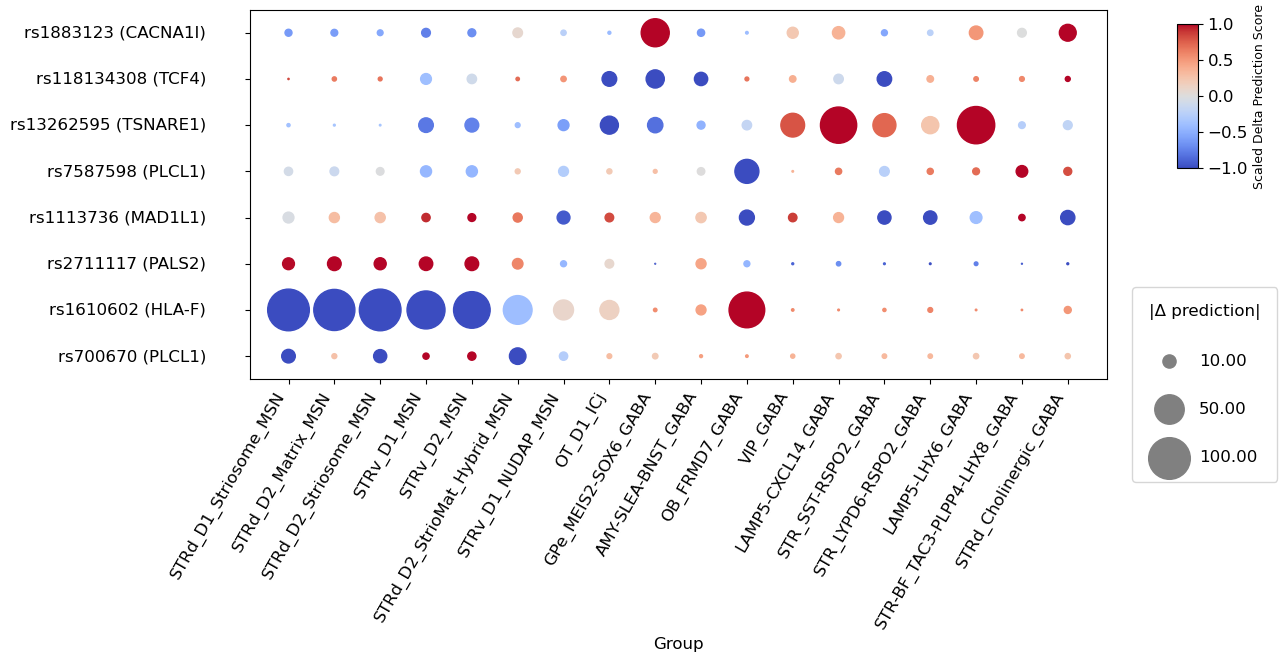

In [ ]:
## ADD THE GENE SYMBOL IN THE INDEX INSTEAD OF THE CELL TYPE ??? OPTIONAL
rsids = df_to_plot.index.get_level_values("rsid")
cell_types = df_to_plot.index.get_level_values("cell_type")
genes = rsids.map(dict_SNPs_Genes)
df_to_plot.index = pd.MultiIndex.from_arrays([rsids, genes], names=["rsid", "gene"])

effect_size_df_subset.index = pd.MultiIndex.from_arrays(
    [effect_size_df_subset.index, genes],
    names=["rsid", "gene"]
)

row_labels_effect_size = [f"{rsid} ({gene})" for rsid, gene in effect_size_df_subset.index]
effect_size_df_subset.index = row_labels_effect_size
print(effect_size_df_subset)

# 1. Color : standardized value (between -1 and 1)
# Standardisation par ligne : centrée réduite (z-score)
df_signed_zscore = df_to_plot.sub(df_to_plot.mean(axis=1), axis=0)
df_signed_zscore = df_signed_zscore.div(df_to_plot.std(axis=1), axis=0)
df_signed_zscore = df_signed_zscore.clip(-1, 1)


# 2. Size : raw absolute value, rescaled between [0, 1]
df_magnitude = df_to_plot.abs()
df_magnitude_scaled = df_magnitude.div(df_magnitude.max(axis=1), axis=0).fillna(0)



row_labels = [f"{rsid} ({gene})" for rsid, gene in df_to_plot.index]
output_names = df_signed_zscore.columns.tolist()  # cell types


df_signed_zscore.index = row_labels
df_magnitude_scaled.index = row_labels

df_valid = pd.DataFrame(index=row_labels) ## WITHOUT THE EFFECT SIZE

plot_prediction_scatter_grid(
    signed_scaled_delta=df_signed_zscore.values,
    magnitude_delta=df_magnitude.values,
    #df_valid=effect_size_df_subset,
    df_valid = df_valid,
    output_names=output_names,
    size_scale=9,  
    font_size=12,
    figsize=(14, len(row_labels) * 0.6), 
    cmap='coolwarm'
    #save_path = f'/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Alma/figures/CRESTED_figures/Recap_top20_scatterplot_{pheno}.svg'  
)




In [ ]:
## ADD LD INFORMATION FOR THE SNPs of INTEREST: 

names = ["chr1", "pos1", "rsid1", "chr2", "pos2", "rsid2", "R2"]
ld_df = pd.read_csv("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/BasalGanglia/external/Disease_related/raw_GWAS_data/SCZ/cleaned_files/LD_expanded_all.ld", 
                     names = names, delim_whitespace=True, header = None)
print(ld_df.head())

##Extract the rsids of interest: 
print(len(list_genes_connected))
ld_df_subset = ld_df[
    (ld_df["rsid1"].isin(list_genes_connected)) &
    (ld_df["rsid2"].isin(list_genes_connected))
    ]

print(ld_df_subset.shape)
print(len(ld_df_subset["rsid1"].unique().tolist()))

for rsid in list_genes_connected:
    actual_LD = ld_df_subset[ld_df_subset["rsid1"] == rsid]
    if actual_LD.shape[0] > 1:
        print(actual_LD)

   chr1     pos1      rsid1  chr2     pos2       rsid2        R2
0     2  2330118  rs6708950     2  2304650  rs11897032  0.833592
1     2  2330118  rs6708950     2  2304650  rs11897032  0.833592
2     2  2330118  rs6708950     2  2305125   rs6710116  0.847407
3     2  2330118  rs6708950     2  2309608  rs13391117  0.994574
4     2  2330118  rs6708950     2  2309927   rs7580422  0.994574
8
(8, 7)
8
